## GAOFEN
Here I will make the first attempts on multidimensional images, mainly I will try to use Gaofen images.


LAST VERSION

Source: https://x-ytong.github.io/project/Five-Billion-Pixels.html


OLD VERSION

Source: https://captain-whu.github.io/GID15/

FiveMillionPixels: https://drive.google.com/drive/folders/1924VnO08Gqo3Nv7Y4KirgJ9kqqCup7f0

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random, tifffile
from matplotlib import pyplot as plt

from shapely.geometry import Polygon

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.structures import BoxMode

## Start processing info

In [36]:
dataset_path_image = 'datasets/gaofen/Image__8bit_NirRGB/' 
#dataset_path_image = 'datasets/gaofen/Image_16bit_BGRNir/' 
dataset_path_png_mask = 'datasets/gaofen/Annotation__index/'
dataset_path_tif_mask = 'datasets/gaofen/Annotation__color/'

In [3]:
# Load the TIFF image
#image = tifffile.imread(f'{dataset_path}gaofen/img_dir/train/GF2_PMS1__L1A0000564539-MSS1.tif')

first_image_filename = "GF2_PMS1__L1A0000564539-MSS1"
#first_image_filename = "GF2_PMS1__L1A0000575925-MSS1"
#first_image_filename = "GF2_PMS1__L1A0001094941-MSS1"

image = cv2.imread(f'{dataset_path_image}{first_image_filename}.tif', cv2.IMREAD_UNCHANGED)

print("Image shape:", image.shape)
print("Image data type:", image.dtype)

# Show the image
cv2.imshow('TIFF Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Image shape: (6908, 7300, 4)
Image data type: uint8


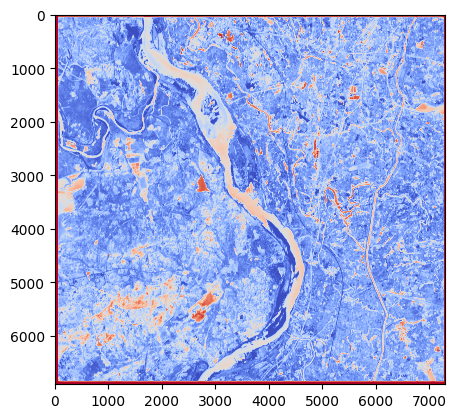

In [4]:
img = plt.imread(f'{dataset_path_image}{first_image_filename}.tif')
plt.imshow(img[:, :, 0], cmap=plt.cm.coolwarm)

In [5]:
mask_png = cv2.imread(f'{dataset_path_png_mask}{first_image_filename}_24label.png', cv2.IMREAD_UNCHANGED)
mask_tif = cv2.imread(f'{dataset_path_tif_mask}{first_image_filename}_24label.tif', cv2.IMREAD_UNCHANGED)


# Show the image
cv2.imshow('PNG MASK', mask_png)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("PNG MASK shape:", mask_png.shape)
print("PNG MASK data type:", mask_png.dtype)

# Show the image
cv2.imshow('TIFF MASK', mask_tif)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("TIFF MASK shape:", mask_tif.shape)
print("TIFF MASK data type:", mask_tif.dtype)

PNG MASK shape: (6908, 7300)
PNG MASK data type: uint8
TIFF MASK shape: (6908, 7300, 3)
TIFF MASK data type: uint8


## Turn each image into 16 smaller images

In [6]:
def divide_image_into_quadrants(image, n):
    
    if(len(image.shape) == 3):
        rows, cols, _ = image.shape  
    else:
        rows, cols = image.shape  
    
    
    # Calculate the number of rows and columns for the grid
    num_rows = int(n ** 0.5)
    num_cols = n // num_rows
    
    # Calculate the dimensions of each quadrant
    quadrant_rows = rows // num_rows
    quadrant_cols = cols // num_cols
    
    # Initialize a list to store the quadrants
    quadrants = []
    
    # Iterate over the rows and columns to extract each quadrant
    for i in range(num_rows):
        for j in range(num_cols):
            # Define the region of interest (ROI) for the quadrant
            start_row = i * quadrant_rows
            end_row = start_row + quadrant_rows
            start_col = j * quadrant_cols
            end_col = start_col + quadrant_cols
            
            # Extract the quadrant
            quadrant = image[start_row:end_row, start_col:end_col]
            quadrants.append(quadrant)
    
    return quadrants


In [7]:
number_of_quadrants = 16

image_train = cv2.imread(f'{dataset_path_image}{first_image_filename}.tif', cv2.IMREAD_UNCHANGED)
images_train = divide_image_into_quadrants(image, number_of_quadrants)

image_mask_tif = cv2.imread(f'{dataset_path_tif_mask}{first_image_filename}_24label.tif', cv2.IMREAD_UNCHANGED)
images_masks_tif = divide_image_into_quadrants(image_mask_tif, number_of_quadrants)

image_mask_png = cv2.imread(f'{dataset_path_png_mask}{first_image_filename}_24label.png', cv2.IMREAD_UNCHANGED)
images_masks_png = divide_image_into_quadrants(image_mask_png, number_of_quadrants)

print(len(images_train))

16


In [8]:
cv2.imwrite("samples/image.jpg",images_train[0])
cv2.imwrite("samples/image_huge.jpg",image)
cv2.imwrite("samples/image_mask.jpg",images_masks_png[0])
cv2.imwrite("samples/image_mask_color.jpg",image_mask_tif)

True

In [9]:
""" for i in images_masks_png:
    # Show the image
    print(i.shape)
    cv2.imshow('TIFF Image', i)
    cv2.waitKey(0)
    cv2.destroyAllWindows() """

" for i in images_masks_png:\n    # Show the image\n    print(i.shape)\n    cv2.imshow('TIFF Image', i)\n    cv2.waitKey(0)\n    cv2.destroyAllWindows() "

## Working with labels

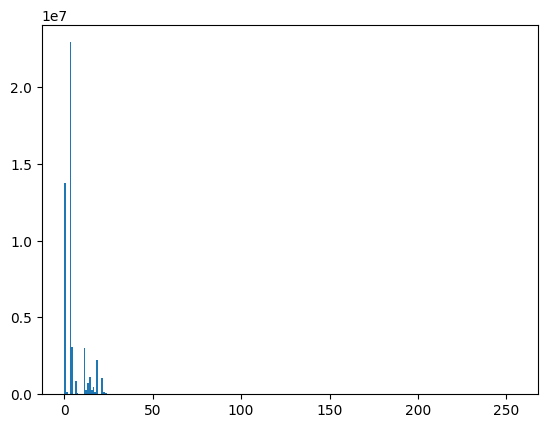

In [10]:
mask_png = cv2.imread(f'{dataset_path_png_mask}{first_image_filename}_24label.png', cv2.IMREAD_UNCHANGED)
mask_tif = cv2.imread(f'{dataset_path_tif_mask}{first_image_filename}_24label.tif', cv2.IMREAD_UNCHANGED)

plt.hist(mask_png.ravel(),255,[0,255]); plt.show()

In [32]:
## Im going to get all bodies of water, pixel_values 13,14,15
def keep_water_pixels(image):
    water_pixels = np.where((image == 13) | (image == 14) | (image == 11))
    other_pixels = np.where((image != 13) & (image != 14) & (image != 11)) # Tengo que cambiar los numeros

    image[water_pixels] = 255
    image[other_pixels] = 0

    return image

def get_polygons_from_mask_gt(img_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #If you use this flag, it returns only extreme outer flags. All child contours are left behind. We can say, under this law, Only the eldest in every family is taken care of. It doesn't care about other members of the family :).

    polygons = []
    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)# Smaller values more accurate results
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)
    return polygons


def get_polygons_and_bbox_from_mask_gt(img_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #If you use this flag, it returns only extreme outer flags. All child contours are left behind. We can say, under this law, Only the eldest in every family is taken care of. It doesn't care about other members of the family :).

    bbox=[]
    polygons = []
    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)# Smaller values more accurate results
        polygon = cv2.approxPolyDP(contour, epsilon, True)

        polygons.append(polygon)
        ## cogemos el maximo de xy y el minimo de xy para guardar la bbox



    return polygons,bbox




######
## Esto solo se usa para mostrar los poligonos
######
def get_representative_polygon_point(polygon):# This code was used to try to find a point inside each polygon, it wasnt useful in the end. Now I use it to print the polygons number
    x_sum = 0
    y_sum = 0
    num_points = len(polygon)
    for point in polygon:
        x_sum += point[0][0]
        y_sum += point[0][1]
    average_x = int(x_sum / num_points)
    average_y = int(y_sum / num_points)
    
    #Returns the average position of the vertices
    return (average_x, average_y)
######
## Esto solo se usa para mostrar los poligonos
######

image_mask_png = cv2.imread(f'{dataset_path_png_mask}{first_image_filename}_24label.png', cv2.IMREAD_UNCHANGED)
images_masks_png = divide_image_into_quadrants(image_mask_png, number_of_quadrants)

for idx,i in enumerate(images_masks_png):
    images_masks_png[idx] = keep_water_pixels(i)

polygons = get_polygons_from_mask_gt(images_masks_png[0])

polygon_image = np.zeros_like(images_masks_png[0])
cv2.drawContours(polygon_image, polygons, -1, (255), 1)

class_coords=[]
for i in polygons:
    class_coords.append(get_representative_polygon_point(i))

for idx, point in enumerate(class_coords):
    # Draw number at each class coordinate
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)  
    thickness = 1
    cv2.putText(polygon_image, str(idx), point, font, font_scale, font_color, thickness)



cv2.imshow('Polygons', polygon_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite("samples/water_polygons.jpg",polygon_image)


True

## Now I have to get the bounding boxes from the polygons

In [12]:
def get_bbox_from_polygon(polygon):
    
    max_values = np.max(polygon, axis=0).flatten()
    min_values = np.min(polygon, axis=0).flatten()

    return [max_values,min_values]

#bbox_coords = get_bbox_from_polygon(polygons[16])

for i in polygons:
    bbox_coords = get_bbox_from_polygon(i)
    cv2.rectangle(polygon_image, bbox_coords[0], bbox_coords[1], (255, 255, 255), 1)



cv2.imshow('Polygons', polygon_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite("samples/bbox_assignation.jpg",polygon_image)

True

## Create Mask2former dictionary

In [13]:
def keep_water_pixels(image):
    water_pixels = np.where((image == 13) | (image == 14) | (image == 11))
    other_pixels = np.where((image != 13) & (image != 14) & (image != 11)) # Tengo que cambiar los numeros

    image[water_pixels] = 255
    image[other_pixels] = 0

    return image


def get_polygons_from_mask_gt(img_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #If you use this flag, it returns only extreme outer flags. All child contours are left behind. We can say, under this law, Only the eldest in every family is taken care of. It doesn't care about other members of the family :).

    polygons = []
    for contour in contours:
        epsilon = 0.000000001 * cv2.arcLength(contour, True)# Smaller values more accurate results
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

    return polygons


def get_bbox_from_polygon(polygon):
    
    max_values = np.max(polygon, axis=0).flatten()
    min_values = np.min(polygon, axis=0).flatten()

    return [max_values,min_values]


def get_gaofen_dict(images_path, ground_truth_dir):# Por como esta organizado el dataset creo que es mejor empezar desde la carpeta de bboxes
    # Hay que proporcionar un list[dict] que contenga los siguientes campos, se supone que se hace esto una vez para train y otra para eval
    
    dataset_dicts = []
    number_of_images = len(os.listdir(images_path))
    for image_idx, image_filename in enumerate(os.listdir(images_path)):

        print(f"{image_filename} is image {image_idx+1} out of {number_of_images}\n")
        record={}

        image_file_path = os.path.join(images_path, image_filename)  # Get the full path of the file


        image_id = image_filename[:-4]# eliminar el .tif para tener el image_id 
                                    # (str or int): a unique id that identifies this image. 
                                    #Required by many evaluators to identify the images, but a dataset may use it for different purposes.


        height, width = cv2.imread(image_file_path, cv2.IMREAD_UNCHANGED).shape[:2]

        record["file_name"] = image_file_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        # Aqui consigo todos los polígonos posibles a partir de cada gt mask
        mask_gt_filepath = os.path.join(ground_truth_dir, image_id + '_24label.png')
        img_mask = keep_water_pixels(cv2.imread(mask_gt_filepath, cv2.IMREAD_UNCHANGED))


        ####### Hasta aquí la imagen se guarda correctamente

        possible_polygons = get_polygons_from_mask_gt(img_mask)## Aqui tengo la lista de posibles poligonos
        
        # Bucle para acceder a las anotaciones de cada bbox, se creara un diccionario por cada bbox y se añadirá a la lista annotations (list[dict])
        annotations = []
        for polygon in possible_polygons:
            bbox_record = {}
            
            temp_bbox = get_bbox_from_polygon(polygon)
            bbox_record["bbox"] = (temp_bbox[0][0], temp_bbox[0][1], temp_bbox[1][0], temp_bbox[1][1])
            bbox_record["bbox_mode"] = BoxMode.XYXY_ABS
            bbox_record["category_id"] = 0

            if len(polygon)<4:
                print("arreglar poli")
                while(len(polygon)<4):
                    polygon = np.append(polygon, [polygon[-1]], axis=0)
                if(len(polygon)==4):
                    print("Arreglado")
                    print(polygon)
            bbox_record["segmentation"] = [polygon]

            annotations.append(bbox_record)
        
        record["annotations"] = annotations    

        # ahora hay que proporcionar la direccion a los gt de segmentacion panoptica
        # pan_seg_file_name = os.path.join(ground_truth_dir, image_id + '.jpg')
        
        # Proporcionar la info de los segmentos list[dict] CREO QUE NO LOS TENGO

        # para comprobar si soy capaz de cargar un dataset custom voy a emplear la segmentacion semantica...
        #sem_seg_file_name = os.path.join(ground_truth_dir, image_id + '.png')
        #record["sem_seg_file_name"] = sem_seg_file_name



        #End loop and save dict
        dataset_dicts.append(record)
        #### ESTO ES UNA COSA CUTRE PARA PODER HACER PRUEBAS y que para cuando tenga cargadas n imagenes en el formato compatible con detectron
        if(len(dataset_dicts) == 5):
            break

    return dataset_dicts

In [14]:
path_img = "/home/pablo.canosa/wip/datasets/gaofen/Image__8bit_NirRGB/"
path_gt = "/home/pablo.canosa/wip/datasets/gaofen/Annotation__index/"


In [15]:
DatasetCatalog.register("gaofen_train", lambda : get_gaofen_dict(path_img,path_gt))

In [16]:
MetadataCatalog.get("gaofen_train").thing_classes=["water"]
gaofen_metadata = MetadataCatalog.get("gaofen_train")

In [17]:
dataset_dicts = get_gaofen_dict(path_img,path_gt)


GF2_PMS1__L1A0001094941-MSS1.tif is image 1 out of 150

GF2_PMS2__L1A0001537637-MSS2.tif is image 2 out of 150

arreglar poli
Arreglado
[[[5146 5107]]

 [[5146 5107]]

 [[5146 5107]]

 [[5146 5107]]]
GF2_PMS2__L1A0001251800-MSS2.tif is image 3 out of 150

arreglar poli
Arreglado
[[[5818 2057]]

 [[5818 2057]]

 [[5818 2057]]

 [[5818 2057]]]
GF2_PMS2__L1A0001799010-MSS2.tif is image 4 out of 150

GF2_PMS1__L1A0001765574-MSS1.tif is image 5 out of 150



In [18]:
# mostrar imagenes de crops para ver si se cargan bien

# This code snippet is taken from the dectectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 4)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    cv2.waitKey(0) 
    # closing all open windows 
    cv2.destroyAllWindows() 
    cv2.imwrite(f"samples/mask2former{idx}.jpg",out.get_image()[:, :, ::-1])

/home/pablo.canosa/wip/datasets/gaofen/Image__8bit_NirRGB/GF2_PMS1__L1A0001094941-MSS1.tif
/home/pablo.canosa/wip/datasets/gaofen/Image__8bit_NirRGB/GF2_PMS2__L1A0001251800-MSS2.tif
/home/pablo.canosa/wip/datasets/gaofen/Image__8bit_NirRGB/GF2_PMS2__L1A0001799010-MSS2.tif
/home/pablo.canosa/wip/datasets/gaofen/Image__8bit_NirRGB/GF2_PMS2__L1A0001537637-MSS2.tif


## First Mask2former Training

* python train_net_gaofen.py --num-gpus 1 --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/instance-segmentation/maskformer2_R50_bs16_50ep.yaml

## Trials on small dataset version

In [28]:
def keep_water_pixels(image):
    water_pixels = np.where((image == 13) | (image == 14) | (image == 11))
    other_pixels = np.where((image != 13) & (image != 14) & (image != 11)) # Tengo que cambiar los numeros

    image[water_pixels] = 255
    image[other_pixels] = 0

    return image


def get_polygons_from_mask_gt(img_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #If you use this flag, it returns only extreme outer flags. All child contours are left behind. We can say, under this law, Only the eldest in every family is taken care of. It doesn't care about other members of the family :).

    polygons = []
    for contour in contours:
        epsilon = 0.000000001 * cv2.arcLength(contour, True)# Smaller values more accurate results
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

    return polygons


def get_bbox_from_polygon(polygon):
    
    max_values = np.max(polygon, axis=0).flatten()
    min_values = np.min(polygon, axis=0).flatten()

    return [max_values,min_values]


def get_gaofen_dict(images_path, ground_truth_dir):# Por como esta organizado el dataset creo que es mejor empezar desde la carpeta de bboxes
    # Hay que proporcionar un list[dict] que contenga los siguientes campos, se supone que se hace esto una vez para train y otra para eval
    
    dataset_dicts = []
    number_of_images = len(os.listdir(images_path))
    for image_idx, image_filename in enumerate(os.listdir(images_path)):

        print(f"{image_filename} is image {image_idx+1} out of {number_of_images}\n")
        record={}

        image_file_path = os.path.join(images_path, image_filename)  # Get the full path of the file


        image_id = image_filename[:-4]# eliminar el .tif para tener el image_id 
                                    # (str or int): a unique id that identifies this image. 
                                    #Required by many evaluators to identify the images, but a dataset may use it for different purposes.


        height, width = cv2.imread(image_file_path, cv2.IMREAD_UNCHANGED).shape[:2]

        record["file_name"] = image_file_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        # Aqui consigo todos los polígonos posibles a partir de cada gt mask
        mask_gt_filepath = os.path.join(ground_truth_dir, image_id + '_24label.png')
        img_mask = keep_water_pixels(cv2.imread(mask_gt_filepath, cv2.IMREAD_UNCHANGED))


        ####### Hasta aquí la imagen se guarda correctamente

        possible_polygons = get_polygons_from_mask_gt(img_mask)## Aqui tengo la lista de posibles poligonos
        
        # Bucle para acceder a las anotaciones de cada bbox, se creara un diccionario por cada bbox y se añadirá a la lista annotations (list[dict])
        annotations = []
        for polygon in possible_polygons:
            bbox_record = {}
            
            temp_bbox = get_bbox_from_polygon(polygon)
            bbox_record["bbox"] = (temp_bbox[0][0], temp_bbox[0][1], temp_bbox[1][0], temp_bbox[1][1])
            bbox_record["bbox_mode"] = BoxMode.XYXY_ABS
            bbox_record["category_id"] = 0

            # Esto es una burrada temporal pero creo que puedo defender el hacerlo asi porque las instancias muy pequeñas me generan poligonos de menos de 4 
            # puntos entonce que el poligono esté formado por el mismo punto varias veces no debería tener un efecto muy dañino

            if len(polygon)<4:
                print("arreglar poli")
                while(len(polygon)<4):
                    polygon = np.append(polygon, [polygon[-1]], axis=0)
                if(len(polygon)==4):
                    print("Arreglado")
                    print(polygon)
            bbox_record["segmentation"] = [polygon]

            annotations.append(bbox_record)
        
        record["annotations"] = annotations    

        # ahora hay que proporcionar la direccion a los gt de segmentacion panoptica
        # pan_seg_file_name = os.path.join(ground_truth_dir, image_id + '.jpg')
        
        # Proporcionar la info de los segmentos list[dict] CREO QUE NO LOS TENGO

        # para comprobar si soy capaz de cargar un dataset custom voy a emplear la segmentacion semantica...
        #sem_seg_file_name = os.path.join(ground_truth_dir, image_id + '.png')
        #record["sem_seg_file_name"] = sem_seg_file_name



        #End loop and save dict
        dataset_dicts.append(record)
        #### ESTO ES UNA COSA CUTRE PARA PODER HACER PRUEBAS y que para cuando tenga cargadas n imagenes en el formato compatible con detectron
        if(len(dataset_dicts) == 5):
            break

    return dataset_dicts

In [27]:
path_img = 'datasets/small_gaofen/train/8bit_images/'
path_gt = '/home/pablo.canosa/wip/datasets/small_gaofen/train/png_masks/'

In [29]:
DatasetCatalog.register("gaofen_train_small", lambda : get_gaofen_dict(path_img,path_gt))

AssertionError: Dataset 'gaofen_train_small' is already registered!

In [30]:
MetadataCatalog.get("gaofen_train_small").thing_classes=["water"]
gaofen_metadata = MetadataCatalog.get("gaofen_train_small")

In [31]:
dataset_dicts = get_gaofen_dict(path_img,path_gt)


GF2_PMS2__L1A0001389317-MSS2_2.tif is image 1 out of 480

arreglar poli
Arreglado
[[[2441 1722]]

 [[2441 1722]]

 [[2441 1722]]

 [[2441 1722]]]
arreglar poli
Arreglado
[[[2262  475]]

 [[2262  475]]

 [[2262  475]]

 [[2262  475]]]
GF2_PMS2__L1A0001708259-MSS2_2.tif is image 2 out of 480

GF2_PMS1__L1A0001668483-MSS1_0.tif is image 3 out of 480

GF2_PMS2__L1A0000948183-MSS2_1.tif is image 4 out of 480

GF2_PMS2__L1A0001573999-MSS2_0.tif is image 5 out of 480



In [24]:
# mostrar imagenes de crops para ver si se cargan bien

# This code snippet is taken from the dectectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 4)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    cv2.waitKey(0) 
    # closing all open windows 
    cv2.destroyAllWindows() 
    cv2.imwrite(f"samples/mask2former{idx}.jpg",out.get_image()[:, :, ::-1])

datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001668483-MSS1_0.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001708259-MSS2_2.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001389317-MSS2_2.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001344822-MSS1_3.tif


## Load PTH model

`python demo.py --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/instance-segmentation/maskformer2_R50_bs16_50ep.yaml --input /home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/GF2_PMS1__L1A0001432972-MSS1_0.tif --opts  MODEL.WEIGHTS /home/pablo.canosa/wip/datasets/small_gaofen/last_checkpoint/instance_segmentation_complete_training/model_final.pth`

## Checkpoint result
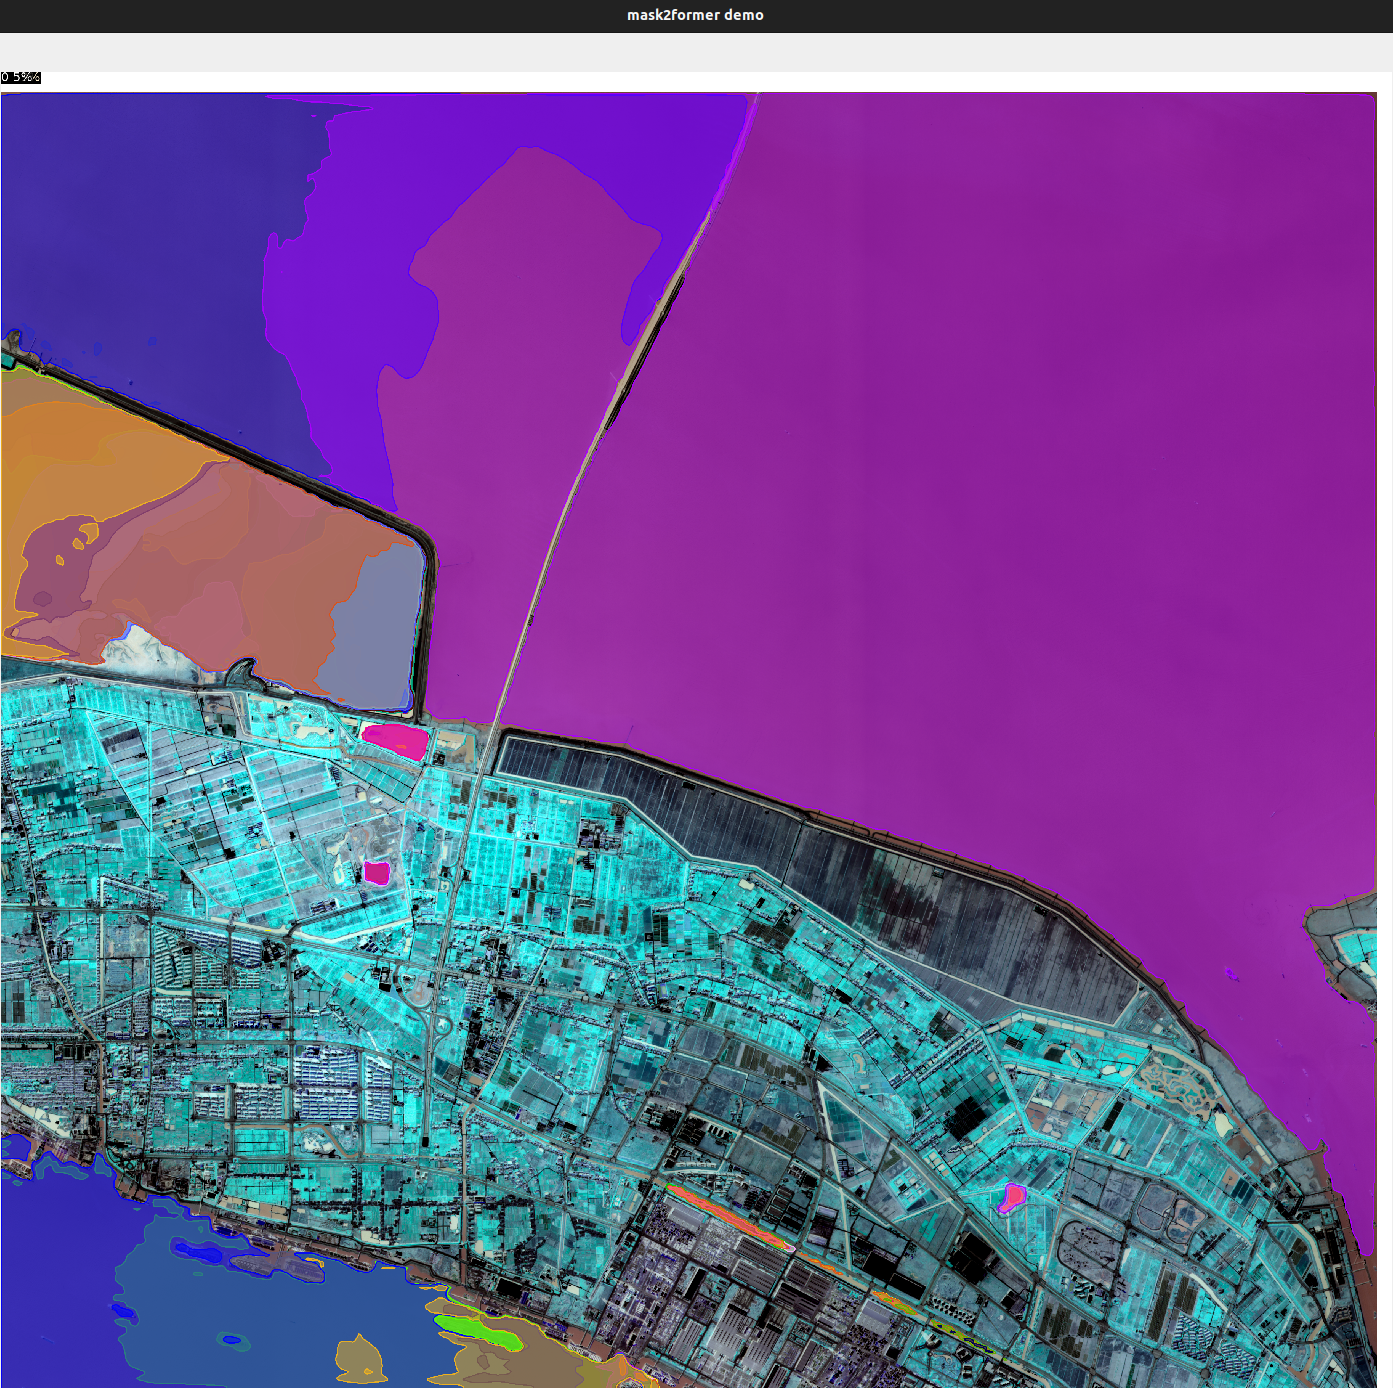

## GT Mask
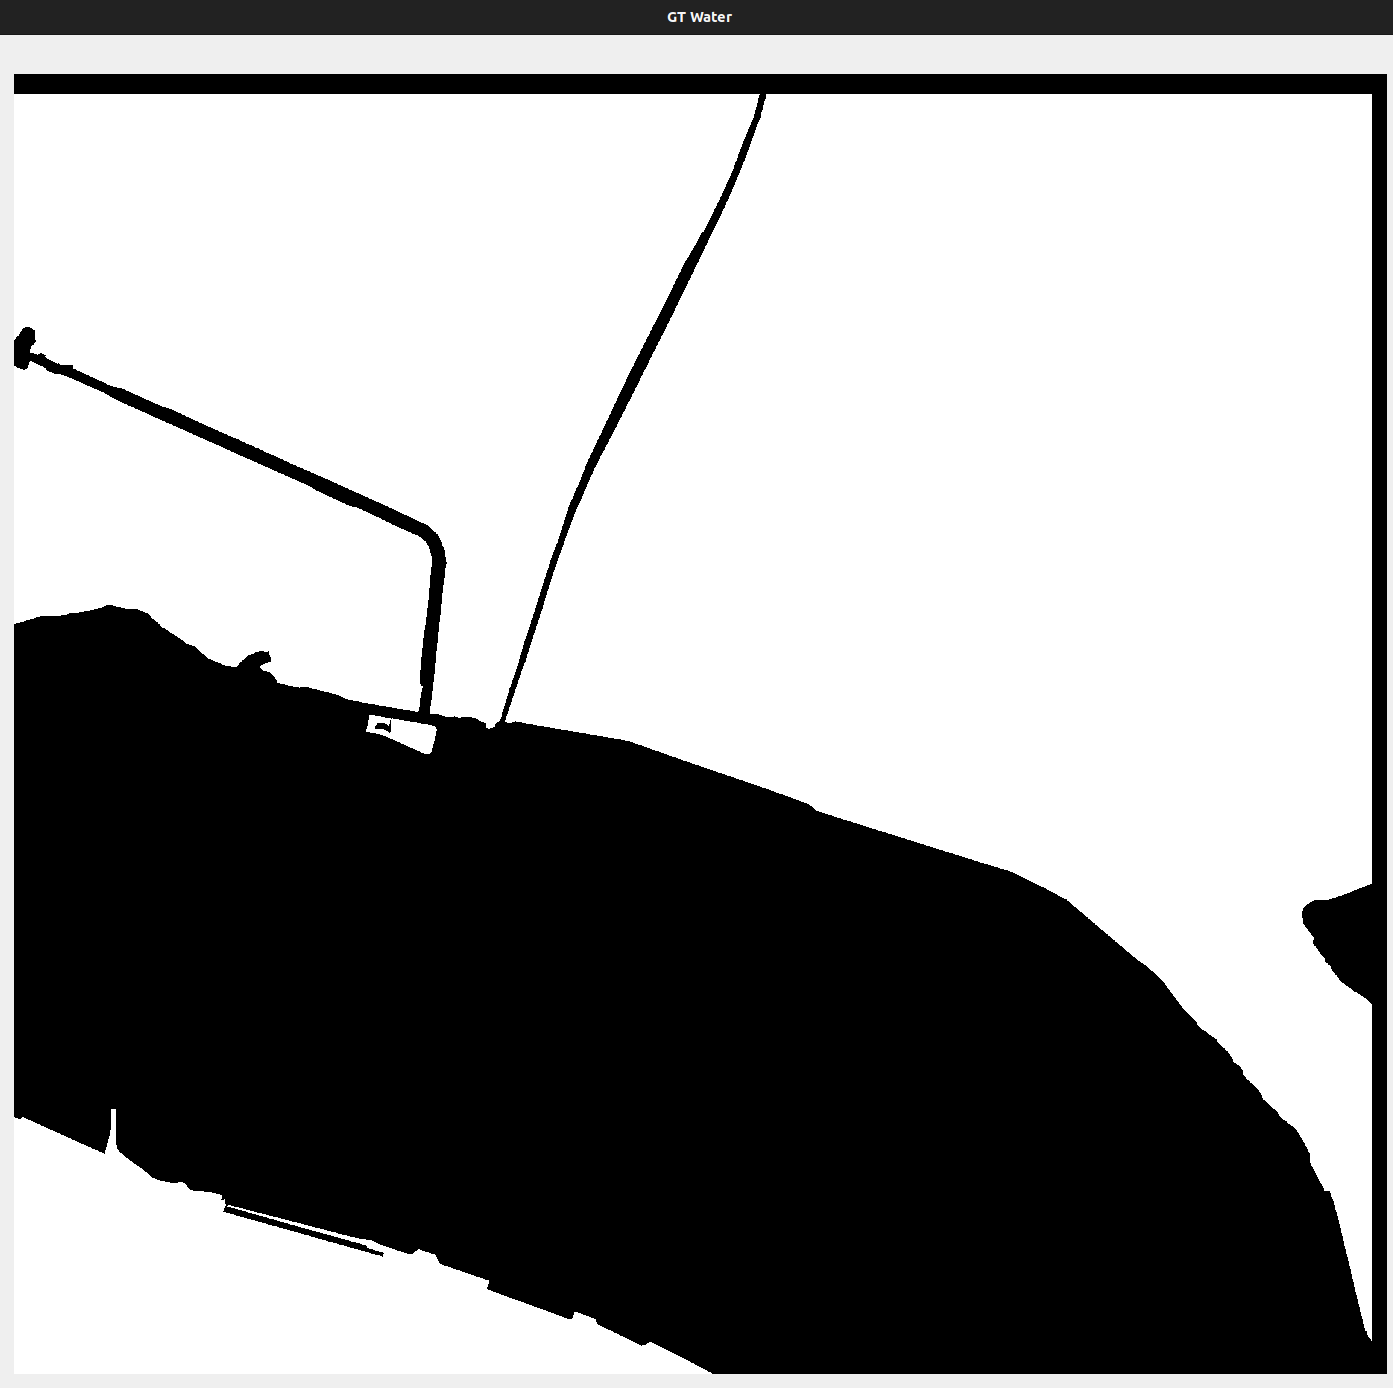

The name of this test image is 'GF2_PMS1__L1A0001432972-MSS1_1.tif'

In [35]:
path_img_test_gt = '/home/pablo.canosa/wip/datasets/small_gaofen/test/test_masks_png/'
img_test_gt = "GF2_PMS1__L1A0001432972-MSS1_1"

image_mask_png = cv2.imread(f'{path_img_test_gt}{img_test_gt}_24label.png', cv2.IMREAD_UNCHANGED)

images_masks_png_gt = keep_water_pixels(image_mask_png)

cv2.namedWindow('GT Water', cv2.WINDOW_NORMAL)# Esto para que la imagen no sea gigante 
cv2.imshow('GT Water', images_masks_png_gt)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Panoptic segmentation training
Now that I have a completely trained model for instance segmentation I should try to get a panoptic model to work.

In [2]:
def keep_water_pixels(image):
    water_pixels = np.where((image == 13) | (image == 14) | (image == 11))
    other_pixels = np.where((image != 13) & (image != 14) & (image != 11)) # Tengo que cambiar los numeros

    image[water_pixels] = 255
    image[other_pixels] = 0

    return image


def get_polygons_from_mask_gt(img_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #If you use this flag, it returns only extreme outer flags. All child contours are left behind. We can say, under this law, Only the eldest in every family is taken care of. It doesn't care about other members of the family :).

    polygons = []
    for contour in contours:
        epsilon = 0.000000001 * cv2.arcLength(contour, True)# Smaller values more accurate results
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

    return polygons


def get_bbox_from_polygon(polygon):
    
    max_values = np.max(polygon, axis=0).flatten()
    min_values = np.min(polygon, axis=0).flatten()

    return [max_values,min_values]


def get_gaofen_dict(images_path, ground_truth_dir):# Por como esta organizado el dataset creo que es mejor empezar desde la carpeta de bboxes
    # Hay que proporcionar un list[dict] que contenga los siguientes campos, se supone que se hace esto una vez para train y otra para eval
    
    dataset_dicts = []
    number_of_images = len(os.listdir(images_path))
    for image_idx, image_filename in enumerate(os.listdir(images_path)):

        print(f"{image_filename} is image {image_idx+1} out of {number_of_images}\n")
        record={}

        image_file_path = os.path.join(images_path, image_filename)  # Get the full path of the file


        image_id = image_filename[:-4]# eliminar el .tif para tener el image_id 
                                    # (str or int): a unique id that identifies this image. 
                                    #Required by many evaluators to identify the images, but a dataset may use it for different purposes.


        height, width = cv2.imread(image_file_path, cv2.IMREAD_UNCHANGED).shape[:2]

        record["file_name"] = image_file_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        # Aqui consigo todos los polígonos posibles a partir de cada gt mask
        mask_gt_filepath = os.path.join(ground_truth_dir, image_id + '_24label.png')
        img_mask = keep_water_pixels(cv2.imread(mask_gt_filepath, cv2.IMREAD_UNCHANGED))


        ####### Hasta aquí la imagen se guarda correctamente

        possible_polygons = get_polygons_from_mask_gt(img_mask)## Aqui tengo la lista de posibles poligonos
        
        # Bucle para acceder a las anotaciones de cada bbox, se creara un diccionario por cada bbox y se añadirá a la lista annotations (list[dict])
        annotations = []
        for polygon in possible_polygons:
            bbox_record = {}
            
            temp_bbox = get_bbox_from_polygon(polygon)
            bbox_record["bbox"] = (temp_bbox[0][0], temp_bbox[0][1], temp_bbox[1][0], temp_bbox[1][1])
            bbox_record["bbox_mode"] = BoxMode.XYXY_ABS
            bbox_record["category_id"] = 0
            

            # Esto es una burrada temporal pero creo que puedo defender el hacerlo asi porque las instancias muy pequeñas me generan poligonos de menos de 4 
            # puntos entonce que el poligono esté formado por el mismo punto varias veces no debería tener un efecto muy dañino

            if len(polygon)<4:
                print("arreglar poli")
                while(len(polygon)<4):
                    polygon = np.append(polygon, [polygon[-1]], axis=0)
                if(len(polygon)==4):
                    print("Arreglado")
                    print(polygon)
            bbox_record["segmentation"] = [polygon]

            annotations.append(bbox_record)
        
        record["annotations"] = annotations    


        #pan_seg_file_name = os.path.join("/home/pablo.canosa/wip/datasets/small_gaofen/train/png_masks/", image_id + '_24label.png')
        
        #Version para probar con las mask de colores
        pan_seg_file_name = os.path.join("/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/", image_id + '_24label.tif')
        record["pan_seg_file_name"] = pan_seg_file_name #keep_water_pixels(pan_seg_file_name) 

        print(pan_seg_file_name) # esto debería estar bien, ya que al printearlas deja acceder a las mismas

        # Version con imagenes en escala de grises
        #record["segments_info"] = [
        #    {'id': 11, 'category_id': 0, 'iscrowd':0},
        #    {'id': 13, 'category_id': 0, 'iscrowd':0},
        #    {'id': 14, 'category_id': 0, 'iscrowd':0}
        #]

        # Version con imagenes a color
        record["segments_info"] = [
            {'id': (0,150,200)  , 'category_id': 0, 'iscrowd':0},
            {'id': (0,200,250)  , 'category_id': 0, 'iscrowd':0},
            {'id': (0,0,200)    , 'category_id': 0, 'iscrowd':0}
        ]


        #End loop and save dict
        dataset_dicts.append(record)
        #### ESTO ES UNA COSA CUTRE PARA PODER HACER PRUEBAS
        if(len(dataset_dicts) == 5):
            break

    return dataset_dicts

In [3]:
path_img = 'datasets/small_gaofen/train/8bit_images/'
path_gt = '/home/pablo.canosa/wip/datasets/small_gaofen/train/png_masks/' # This is for gray scale images


In [4]:
## Esta llega con ejecutarla una vez, porque no puedes registrar el mismo dataset 2 veces :D
DatasetCatalog.register("gaofen_train_small", lambda : get_gaofen_dict(path_img,path_gt))

In [5]:
MetadataCatalog.get("gaofen_train_small").thing_classes=["water"]
gaofen_metadata = MetadataCatalog.get("gaofen_train_small")

In [8]:
dataset_dicts = get_gaofen_dict(path_img,path_gt)


GF2_PMS2__L1A0001389317-MSS2_2.tif is image 1 out of 480

arreglar poli
Arreglado
[[[2441 1722]]

 [[2441 1722]]

 [[2441 1722]]

 [[2441 1722]]]
arreglar poli
Arreglado
[[[2262  475]]

 [[2262  475]]

 [[2262  475]]

 [[2262  475]]]
/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/GF2_PMS2__L1A0001389317-MSS2_2_24label.tif
GF2_PMS2__L1A0001708259-MSS2_2.tif is image 2 out of 480

/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/GF2_PMS2__L1A0001708259-MSS2_2_24label.tif
GF2_PMS1__L1A0001668483-MSS1_0.tif is image 3 out of 480

/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/GF2_PMS1__L1A0001668483-MSS1_0_24label.tif
GF2_PMS2__L1A0000948183-MSS2_1.tif is image 4 out of 480

/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/GF2_PMS2__L1A0000948183-MSS2_1_24label.tif
GF2_PMS2__L1A0001573999-MSS2_0.tif is image 5 out of 480

/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/GF2_PMS2__L1A0001573999-MSS

In [9]:
# mostrar imagenes de crops para ver si se cargan bien

# This code snippet is taken from the dectectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 4)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    cv2.waitKey(0) 
    # closing all open windows 
    cv2.destroyAllWindows() 
    cv2.imwrite(f"samples/mask2former{idx}.jpg",out.get_image()[:, :, ::-1])

datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001573999-MSS2_0.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001668483-MSS1_0.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0000948183-MSS2_1.tif
datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001708259-MSS2_2.tif


I created a new mask2former script fot panoptic called "train_net_gaofen_panoptic.py"

* python train_net_gaofen_panoptic.py --num-gpus 1 --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/panoptic-segmentation/maskformer2_R50_bs16_50ep.yaml

/home/pablo.canosa/wip/Mask2Former/output/model_final.pth

`python demo.py --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/panoptic-segmentation/maskformer2_R50_bs16_50ep.yaml --input /home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/GF2_PMS1__L1A0001432972-MSS1_0.tif --opts  MODEL.WEIGHTS /home/pablo.canosa/wip/Mask2Former/output/model_final.pth`


Im not sure about why is this error popping up, I think, given its trace, that it is related with the color encoding. As I was providing a grayscale image maybve if I use the color mask it will work.

* python train_net_gaofen_panoptic.py --num-gpus 1 --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/panoptic-segmentation/maskformer2_R50_bs16_50ep.yaml

